# $k$-armed Bandit Problem

![Multi-armed bandit](https://miro.medium.com/max/1400/1*5q0Mihf29fftuXpKWWX2uA.png)

> You are faced repeatedly with a choice among $k$ different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps.

You have a set of actions which provide stochastic rewards when taken. There is no "state" in the traditional RL problem sense. You merely have to evaluate and choose the best action as often as you can, while taking time to explore.

The _value_ of any action in this setup is the expected return of that action when taken.

$$
q_*(a) = \mathbb{E}[R_t \mid A_t = a ]
$$

The optimal action is the one for which $q_*(a)$ is highest. Selecting the action which currently has the highest estimated value is acting greedily, i.e _exploiting_ your knowledge rather than _exploring_ for new knowledge.

## Action Value methods

In action value methods, we form an estimate of the value of each action, $Q_t(a)$. The most natural way of doing this is to simply take the average reward for each action.

$$
Q_t(a) \quad \dot{=} \quad \frac{\sum_{i=1}^{t-1}{R_i \mathbb{1}_{A_i=a}}}{\sum_{i=1}^{t-1}{\mathbb{1}_{A_i=a}}}
$$

If we have never taken an action before, however, we use a default action value estimate, such as $0$.

Given our estimates, the greedy move is to always take the action $A_t = argmax_a{Q_t(a)}$. However, in order to explore to further refine our value estimates $Q_t(a)$, we can augment this somewhat by choosing the greedy action only with probability $1 - \epsilon, \epsilon > 0$. This is known as an $\epsilon$-greedy strategy. As the total number of actions that we can take approaches infinity, we will visit every action infinitely often, and so therefore:

$$
\lim{Q_t(a)} = q_*(a) = \mathbb{E}[R_t \mid A_t = a ]
$$

And so, eventually, we will always take the actually best action with $1-\epsilon$ probability.

_Exercise 2.1_
> In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon = 0.5$, what is the probability that the greedy action is selected?

Let $U \sim \mathcal{U}[0, 1]$.

$$
P(A_t = a_\mathrm{greedy}) = P(A_t = a_\mathrm{greedy} \mid U < \epsilon)P(U < \epsilon) + P(A_t = a_\mathrm{greedy} \mid U \ge \epsilon) P(U \ge \epsilon) \\
= \frac{1}{N}\epsilon + 1 (1-\epsilon) \\
= 1 - \frac{N-1}{N}\epsilon \\
= 1 - \frac{1}{2}0.5 = 0.75
$$

## The 10-armed Testbed

_Exercise 2.2: Bandit Example_
> Consider a $k$-armed bandit problem with $k = 4$ actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit algorithm using $\varepsilon$-greedy action selection, sample-average action-value estimates, and initial estimates of $Q_1(a) = 0$, for all $a$. Suppose the initial sequence of actions and rewards is $A_1 = 1, R_1 = 1, A_2 = 2, R_2 = -1, A_3 = 2, R_3 = -2, A_4 = 2, R_4 = 2, A_5 = 3, R_5 = 0$. On some of these time steps the $\varepsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?



| T | A | R |Q(1)|Q(2)|Q(3)|Q(4)|Definitely Not Greedy |Possibly Random
|---|---|---|---|---|---|---|---|---
| 1 | 1 | -1 | -1 | 0 | 0 | 0 | ❌ | ✅
| 2 | 2 | 1 | -1 | 1 | 0 | 0 | ❌ | ✅
| 3 | 2 | -2 | -1 | -0.5 | 0 | 0 | ❌ | ✅
| 4 | 2 | 2 | -1 | 0.33 | 0 | 0 | ✅ | ✅
| 5 | 3 | 0 | -1 | 0.33 | 0 | 0 | ✅ | ✅



_Exercise 2.3_
> In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively

After some sufficiently long period of time, the $\varepsilon = 0.01$ will outperform the other two methods. Specifically, it will eventually pick the optimal action $1-\varepsilon = 0.99 = 99\%$ of the time, while the $\varepsilon = 0.1$ will eventually pick the optimal action $1-\varepsilon = 0.9 = 90\%$ of the time. The $\varepsilon = 0$ case will not necessarily converge to correctly picking the correct action with any probability. Instead, the probability that the greedy method converges to the optimal action is ...

For any given bandit problem with mean vector $\mathbf{\mu} \in \mathbb{R}^{10}$, the long term expected reward per action of an $\varepsilon$ greedy strategy will be $(1-\varepsilon)\max \mu$. Taking the ratio of this term for $\varepsilon = 0.99$ and $\varepsilon = 0.9$, we can see that the average reward per action of for $\varepsilon = 0.99$ will be $\frac{0.99\max \mu}{0.9\max \mu} = 1.1$ times larger than the average reward per action of $\varepsilon = 0.9$. Since the average reward per action determines the rate of growth of $\sum_{t=0}^T{R_t}$, we can infer then that $1.1$ is the asymptotic ratio between the reward for each of these two values of $\varepsilon$

Furthermore, if we assume we draw $k$-armed bandit problems from the distribution described in the chapter, we can estimate the average optimal action as

In [6]:
using Statistics
max_μ = mean([maximum(randn(10)) for _ in 1:10000000])

1.5387432297232815

And therefore calculate the long term expected value per action as for $\varepsilon = 0.99, 0.9$ as

In [7]:
(0.99 * max_μ, 0.9 * max_μ)

(1.5233557974260485, 1.3848689067509534)

### Implementation of Bandit Algorithm

In [236]:
using Distributions
using Plots

function bandit_problem(k; μ=0.0, σp=1.0, σ=1.0)
    mean_distribution = Normal(μ, σp)
    means = rand(mean_distribution, k)
    return Normal.(means, σ)
end

problems = [ bandit_problem(10) for _ in 1:2000 ];

function ε_greedy(;k=10, ε=0.01, initial_value=0.0)
    q_s = fill(initial_value, k)
    n_s = zeros(k)
    return function(dist; t)
        action = rand() < ε ? rand(1:k) : argmax(q_s)
        reward = dist(action)
        n_s[action] += 1
        q_s[action] += (1/n_s[action]) * (reward - q_s[action])
        return reward, action
    end
end

ε_greedy (generic function with 1 method)

In [316]:
function evaluate(agent, problem; T=1000, non_stationary=nothing)
    problem = copy(problem)
    dist(a) = rand(problem[a])
    rewards = []
    actions = []
    correct_actions = []
    for j in 1:T
        r, a = agent(dist; t=j)
        push!(rewards, r)
        push!(actions, a)
        push!(correct_actions, a == argmax(getfield.(problem, :μ)))
        if !isnothing(non_stationary)
            for i in eachindex(problem)
                problem[i] = Normal(problem[i].μ + rand(non_stationary), 1)
            end
        end
    end
    return rewards, actions, correct_actions
end

evaluate (generic function with 2 methods)

In [248]:
rewards = Dict{Float64,Array{Float64,2}}()
actions = Dict{Float64,Array{Float64,2}}()
agents = Dict{Float64,Array{Function,1}}()

for ε in [0, 0.1, 0.01]
    rewards[ε] = Array{Float64,2}(undef, 1000, 2000)
    actions[ε] = Array{Float64,2}(undef, 1000, 2000)
    agents[ε] = []
    for (i, problem) in enumerate(problems)
        agent = ε_greedy(;k=10, ε=ε)
        new_rewards, new_actions = evaluate(agent, problem; T=1000)
        actions[ε][:,i] = new_actions
        rewards[ε][:,i] = new_rewards
        push!(agents[ε], agent)
    end
end

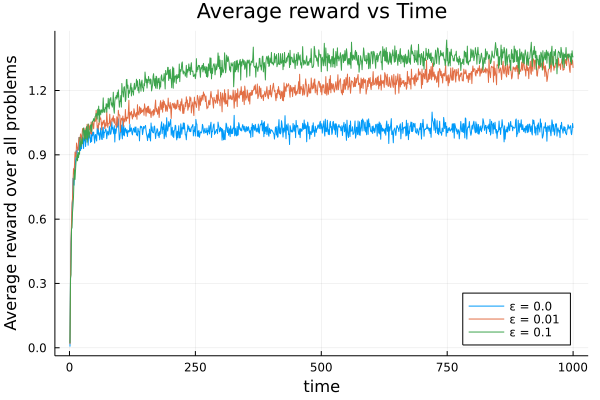

In [331]:
plot(
    [ mean(rewards[0.0], dims=2) mean(rewards[0.01], dims=2) mean(rewards[0.1], dims=2) ],
    label=["ε = 0.0" "ε = 0.01" "ε = 0.1"],
    xlabel="time",
    ylabel="Average reward over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)

In [250]:
optimal_actions = [ argmax([action.μ for action in problem]) for problem in problems]
optimal_action_matrix = repeat(optimal_actions', 1000);

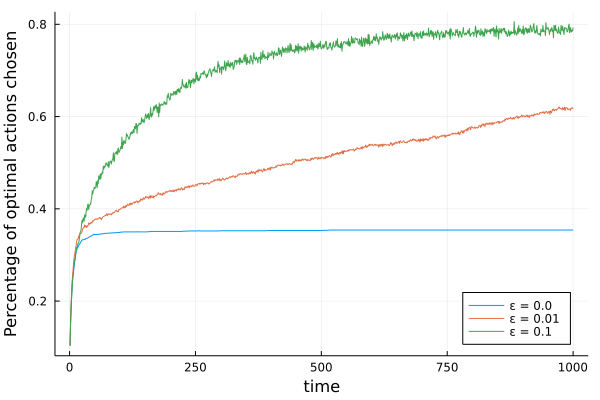

In [251]:
plot(
    [ mean(actions[ε] .== optimal_action_matrix, dims=2) for ε in [0.0, 0.01, 0.1] ],
    label=["ε = 0.0" "ε = 0.01" "ε = 0.1"],
    xlabel="time",
    ylabel="Percentage of optimal actions chosen",
    legend=:bottomright
)

In [252]:
action_values = hcat(map(p -> getfield.(p, :μ), problems)...);

In [253]:
bar(
    [mean((hcat(getfield.(agents[ε], :q_s)...) - action_values).^2) for ε in [0.0, 0.01, 0.1]], 
    xticks=(1:3, ["ε = 0.0" "ε = 0.01" "ε = 0.1"]),
    ylabel="MSE of action value estimate",
    title="MSE of action value estimate vs ε"
)

LoadError: type #364#366 has no field q_s

_Exercise 2.4_
> If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?

$$
Q_{n+1} = Q_1\prod_{i=1}^n{(1-\alpha(i))} + \sum_{i=1}^n{\alpha(i)R_i \prod_{j=i+1}^n{1-\alpha(j)}}
$$

And therefore, the "weight" on reward $i$ becomes

$$
W_i = \alpha(i)\prod_{j=1}^n{1-\alpha(j)}
$$

$$
W_i = \sum_{i=1}^n{\beta(i)R_i \prod_{j=i+1}^n{1-\beta(j)}}
$$

_Exercise 2.5_
> Design and conduct an experiment to demonstrate the diculties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\varepsilon = 0.1$ and longer runs, say of 10,000 steps.

In [256]:
function ε_greedy_ns(;k=10, ε=0.01, α=n->1/n)
    q_s = zeros(k)
    n_s = zeros(k)
    return function(dist; t=1)
        action = rand() < ε ? rand(1:k) : argmax(q_s)
        reward = dist(action)
        n_s[action] += 1
        q_s[action] += α(n_s[action]) * (reward - q_s[action])
        return reward, action
    end
end

ε_greedy_ns (generic function with 1 method)

In [257]:
function evaluate_all_ns(problems; ε, α, T)
    rewards = Array{Float64,2}(undef, T, 2000)
    actions = Array{Float64,2}(undef, T, 2000)
    correct_action = Array{Float64,2}(undef, T, 2000)
    for (i, problem) in enumerate(problems)
        agent = ε_greedy_ns(;k=10, ε=ε, α=α)
        dist(a) = rand(problem[a])
        new_rewards, new_actions, new_correct_action = evaluate(agent, problem; T=T, non_stationary=Normal(0.0, 0.01))
        actions[:,i] = new_actions
        rewards[:,i] = new_rewards
        correct_action[:,i] = new_correct_action
    end
    return actions, rewards, correct_action
end

evaluate_all_ns (generic function with 1 method)

In [258]:
function bandit_problem_equal(k)
    mean = randn()
    [ Normal(mean, 1) for i in 1:k ]
end

bandit_problem_equal (generic function with 1 method)

In [259]:
problems_ns = [ bandit_problem_equal(10) for _ in 1:2000 ];

In [260]:
const_α_actions, const_α_rewards, const_α_correct = evaluate_all_ns(problems_ns; ε=0.1, α=n->0.1, T=10_000);

In [261]:
av_actions, av_rewards, av_correct = evaluate_all_ns(problems_ns; ε=0.1, α=n->1/n, T=10_000);

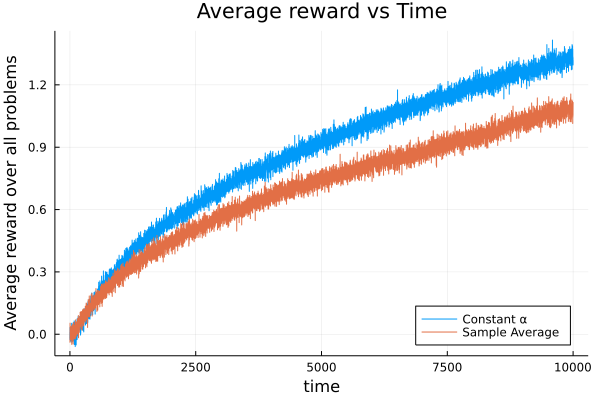

In [262]:
plot(
    [ mean(const_α_rewards, dims=2) mean(av_rewards, dims=2) ],
    label=["Constant α" "Sample Average"],
    xlabel="time",
    ylabel="Average reward over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)

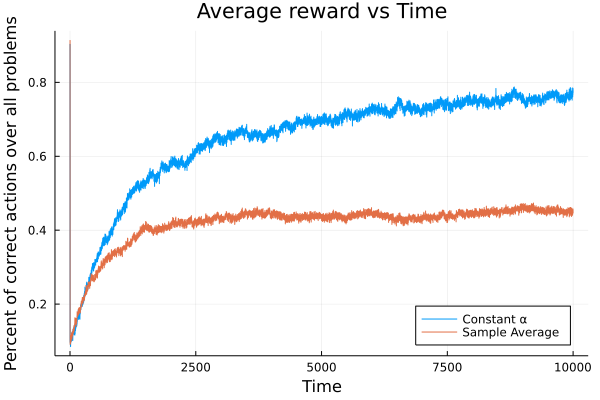

In [263]:
plot(
    [ mean(const_α_correct, dims=2) mean(av_correct, dims=2) ],
    label=["Constant α" "Sample Average"],
    xlabel="Time",
    ylabel="Percent of correct actions over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)

## Optimistic Initial Action Values

In [323]:
rewards_opt = Dict{Float64,Array{Float64,2}}()
actions_opt = Dict{Float64,Array{Float64,2}}()
agents_opt = Dict{Float64,Array{Function,1}}()

for (ε, initial_value) in [(0.1, 0.0), (0.1, -5.0), (0.0, 5.0)]
    rewards_opt[initial_value] = Array{Float64,2}(undef, 1000, 2000)
    actions_opt[initial_value] = Array{Float64,2}(undef, 1000, 2000)
    agents_opt[initial_value] = []
    for (i, problem) in enumerate(problems)
        agent = ε_greedy(;k=10, ε=ε, initial_value=initial_value)
        new_rewards, new_actions = evaluate(agent, problem; T=1000)
        actions_opt[initial_value][:,i] = new_actions
        rewards_opt[initial_value][:,i] = new_rewards
        push!(agents_opt[initial_value], agent)
    end
end

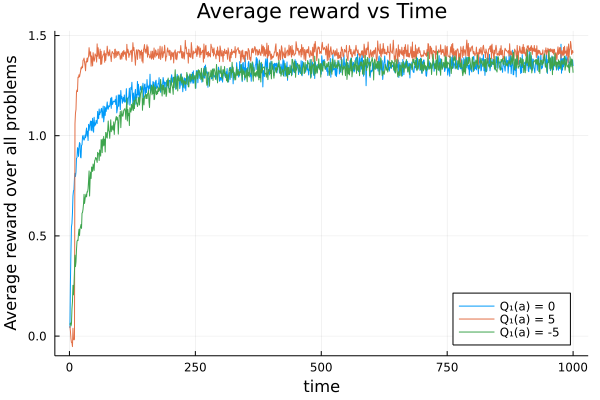

In [327]:
plot(
    [ mean(rewards_opt[0.0], dims=2) mean(rewards_opt[5.0], dims=2) mean(rewards_opt[-5.0], dims=2) ],
    label=["Q₁(a) = 0" "Q₁(a) = 5" "Q₁(a) = -5"],
    xlabel="time",
    ylabel="Average reward over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)

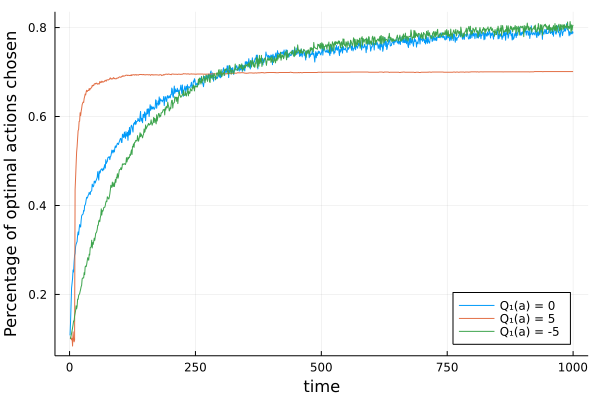

In [328]:
plot(
    [ mean(actions_opt[initial_value] .== optimal_action_matrix, dims=2) for initial_value in [0.0, 5.0, -5.0] ],
    label=["Q₁(a) = 0" "Q₁(a) = 5" "Q₁(a) = -5"],
    xlabel="time",
    ylabel="Percentage of optimal actions chosen",
    legend=:bottomright
)

_Exercise 2.6_
> The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?

The optimistic method is likely to oscillate early since optimism will force it to evaluate each action for a substantial amount of time before it's average approximates it's actual value. This means that even bad actions will be tried frequently until the action values converge.

_Exercise 2.7_
> In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on nonstationary problems? One way is to use a step size of

$$
\beta_n \dot{=} \bar{o}_n
$$
> to process the nth reward for a particular action, where ↵ > 0 is a conventional constantstep size, and ¯on is a trace of one that starts at 0:

$$
\bar{o}_n \dot{=} \bar{o}_{n-1} + \alpha(1 - \bar{o}_{n-1}) \; \mathrm{for} \; n\ge0\mathrm{, with}\;\bar{o}_0 \dot{=} 0
$$
> Carry out an analysis like that in (2.6) to show that Qn is an exponential recency-weighted average without initial bias.


## Upper-Confidence-Bound Action Selection

In [340]:
function ucb_agent(;k=10, c=1.0, initial_value=0.0)
    q_s = fill(initial_value, k)
    n_s = zeros(k)
    return function(dist; t)
        action = argmax(q_s + c * sqrt.(log(t) ./ n_s))
        reward = dist(action)
        n_s[action] += 1
        q_s[action] += (1/n_s[action]) * (reward - q_s[action])
        return reward, action
    end
end

ucb_agent (generic function with 1 method)

In [341]:
function evaluate_ucb(problems; c, T, non_stationary)
    rewards = Array{Float64,2}(undef, T, 2000)
    actions = Array{Float64,2}(undef, T, 2000)
    correct_action = Array{Float64,2}(undef, T, 2000)
    for (i, problem) in enumerate(problems)
        agent = ucb_agent(;k=10, c=c)
        dist(a) = rand(problem[a])
        new_rewards, new_actions, new_correct_action = evaluate(agent, problem; T=T)
        actions[:,i] = new_actions
        rewards[:,i] = new_rewards
        correct_action[:,i] = new_correct_action
    end
    return actions, rewards, correct_action
end

evaluate_ucb (generic function with 1 method)

In [342]:
actions_ucb, rewards_ucb, correct_action_ucb = evaluate_ucb(problems; c=2.0, T=1000, non_stationary=nothing);

In [343]:
actions_ucb10, rewards_ucb10, correct_action_ucb10 = evaluate_ucb(problems; c=10.0, T=1000, non_stationary=nothing);

In [336]:
plotly()

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /Users/maxwellrussek/.julia/packages/Plots/1RWWg/src/backends.jl:432


Plots.PlotlyBackend()

In [339]:
plot(
    [mean(rewards_ucb, dims=2) mean(rewards_ucb10, dims=2)],
    label=["UCB c = 2" "UCB c = 10"],
    xlabel="time",
    ylabel="Average reward over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)

_Exercise 2.8: UCB Spikes_
> In Figure 2.4 the UCB algorithm shows a distinct spikein performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: If $c = 1$, then the spike is less prominent.

This is because the eleventh step is the first where the algorithm actually considers the estimated value $Q_t(a)$ (all the previous steps had $N_t(a) = 0$ for some $a$ and therefore were forced to choose some unexplored action). Additionally, since at $t = 11$ we have explored each action $a$ at least once, so we should expect to choose a better action at this time step. However, after we choose the best action at time $t = 11$ we would expect rewards to decrease as we have to further continue exploring the other actions, whose UCB terms cause them to pre-dominate after $t = 11$. The dependence on $c$ is due to the fact that $c$ determines the relative contribution of the action estimate (which is dominant at $t = 10$ but ceases to dominate subsequently, based on the particular value of $c$).

## Gradient Bandit Algorithms

In [344]:
function gradient_agent(;k=10, α=1.0, initial_value=0.0, baseline=true)
    H_a = fill(initial_value, k)
    reward_sum = 0.0
    N = 0
    return function(dist; t)
        pi = exp.(H_a) / sum(exp.(H_a))
        action = argmax(rand(Multinomial(1, pi)))
        reward = dist(action)
        reward_sum += reward
        N += 1
        reward_mean = baseline ? (reward_sum / N) : 0.0
        for i in 1:k
            if action == i
                H_a[i] += α*(reward - reward_mean)*(1 - pi[action])
            else
                H_a[i] -= α*(reward - reward_mean)*pi[action]
            end
        end
        return reward, action
    end
end

gradient_agent (generic function with 1 method)

In [345]:
function evaluate_gradient(problems; α=1.0, baseline=true, T=1000, non_stationary=nothing)
    rewards = Array{Float64,2}(undef, T, 2000)
    actions = Array{Float64,2}(undef, T, 2000)
    correct_action = Array{Float64,2}(undef, T, 2000)
    for (i, problem) in enumerate(problems)
        agent = gradient_agent(;k=10, α=α, baseline=baseline)
        new_rewards, new_actions, new_correct_action = evaluate(agent, problem; T=T, non_stationary=non_stationary)
        actions[:,i] = new_actions
        rewards[:,i] = new_rewards
        correct_action[:,i] = new_correct_action
    end
    return actions, rewards, correct_action
end

evaluate_gradient (generic function with 1 method)

In [346]:
problems_gradient = [ bandit_problem(10; μ=4.0) for _ in 1:2000 ];

In [349]:
actions_grad_baseline, rewards_grad_baseline, correct_actions_baseline = evaluate_gradient(problems; baseline=true)
actions_grad_no_baseline, rewards_grad_no_baseline, correct_actions_no_baseline = evaluate_gradient(problems; baseline=false);

In [348]:
plot(
    [mean(rewards_grad_baseline, dims=2) mean(rewards_grad_no_baseline, dims=2)],
    label=["∇ bandit (baseline)" "∇ bandit (no baseline)"],
    xlabel="time",
    ylabel="Average reward over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)

In [350]:
plot(
    [ mean(correct_actions_baseline, dims=2) mean(correct_actions_no_baseline, dims=2) ],
    label=["Constant α" "Sample Average"],
    xlabel="Time",
    ylabel="Percent of correct actions over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)

_Exercise 2.9_
> Show that in the case of two actions, the soft-max distribution is the sameas that given by the logistic, or sigmoid, function often used in statistics and artificial neural networks.

$$
P(A_t = a_1) = \frac{e^{H(a_1)}}{e^{H(a_1)} + e^{H(a_2)}} = \frac{1}{1 + e^{-(H(a_1)-H(a_2))}} = \sigma(H(a_1) - H(a_2))
$$